<h2>Libraries and functions used throughout the notebook</h2>

In [5]:
import os
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import networkx as nx
import pycountry
import requests
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import requests
from requests.exceptions import ConnectionError, Timeout, RequestException
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

pd.set_option('display.max_rows', None) # Comment this out if needed

def get_sentiment(text):
    if text == 0:
        return 'NaN'
    return TextBlob(text).sentiment.polarity

def get_country_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None
    
def get_neighbors_from_api(country_code):
    url = f"https://restcountries.com/v3.1/alpha/{country_code}"
    response = requests.get(url)
    if response.status_code == 200:
        country_data = response.json()
        return country_data[0].get('borders', [])
    return []

def get_neighbors(iso_code):
    if iso_code in G:
        return list(G.neighbors(iso_code))
    return []

def countries_in_conflict(year):
    return final_merged_dataframe[(final_merged_dataframe['year'] == year) & (final_merged_dataframe['intensity_level'] > 0)]['ISO-alpha3 Code'].dropna().values

def has_neighbor_in_conflict(row):
    if pd.isna(row['ISO-alpha3 Code']):
        return False
    neighbors = get_neighbors(row['ISO-alpha3 Code'])
    conflicting_countries = countries_in_conflict(row['year'])
    return any(neighbor in conflicting_countries for neighbor in neighbors)

def select_row(group):
    if (group['intensity_level'] == 2).any():
        return group[group['intensity_level'] == 2].iloc[0]
    elif (group['intensity_level'] == 1).any():
        return group[group['intensity_level'] == 1].iloc[0]
    else:
        return group.iloc[0]
    
def check_api_health():
    url = "https://example.com/api/health"
    try:
        response = session.get(url, timeout=5)
        if response.status_code == 200:
            print("API is functioning normally.")
            return True
        else:
            print(f"API health check failed with status: {response.status_code}")
            return False
    except (ConnectionError, Timeout, RequestException) as e:
        print(f"API health check error: {e}")
        return False

<h2>Import the Datasets</h2>

A few country names in the datasets have been hardcoded to a more convenient name

In [6]:
WORKING_DIRECTORY = os.getcwd()
DATA = os.path.join(WORKING_DIRECTORY, 'data')
HAPPINESS_CLEAN = os.path.join(DATA, 'processed', 'happiness_clean.csv')
CONFLICT_CLEAN = os.path.join(DATA, 'processed', 'conflict_clean.csv')
UNGDC_PARQUET = os.path.join(DATA, 'processed', 'UNGDC_1946-2023_processed.parquet')
FINAL_MERGED_DATASET = os.path.join(DATA, 'final_dataset_processed.xlsx')

In [57]:
happinessdataframe = pd.read_csv(HAPPINESS_CLEAN)
happinessdataframe['Country Code'] = happinessdataframe['Country name'].apply(get_country_code)

happinessdataframe.loc[happinessdataframe['Country name'] == 'Congo (Brazzaville)', 'Country name'] = 'Congo'
happinessdataframe.loc[happinessdataframe['Country name'] == 'Congo (Kinshasa)', 'Country name'] = 'Congo'

In [58]:
conflictdataframe = pd.read_csv(CONFLICT_CLEAN)

conflict_post2004 = conflictdataframe[conflictdataframe['year'] > 2004]
conflict_post2004.loc[conflict_post2004['location'] == 'Russia (Soviet Union)', 'location'] = 'Russia'
conflict_post2004.loc[conflict_post2004['location'] == 'Russia (Soviet Union), Ukraine', 'location'] = 'Ukraine'
conflict_post2004.loc[conflict_post2004['location'] == 'DR Congo (Zaire)', 'location'] = 'Congo'

conflictdataframe = conflict_post2004

In [59]:
ungdc = pd.read_parquet(UNGDC_PARQUET)
ungdc.head()

,Session,Year,ISO-alpha3 Code,Speech
0,01,1946,ARG,At the resumption of the first session of the ...
1,01,1946,AUS,The General Assembly of the United Nations is ...
2,01,1946,BEL,The\tprincipal organs of the United Nations ha...
3,01,1946,BLR,As more than a year has elapsed since the Unit...
4,01,1946,BOL,Coming to this platform where so many distingu...


In [60]:
print(ungdc[ungdc['ISO-alpha3 Code'] == 'COD'])

      Session  Year ISO-alpha3 Code  \
801        16  1961             COD   
977        18  1963             COD   
1273       21  1966             COD   
1379       22  1967             COD   
1491       23  1968             COD   
1604       24  1969             COD   
1789       26  1971             COD   
1909       27  1972             COD   
2032       28  1973             COD   
2156       29  1974             COD   
2284       30  1975             COD   
2410       31  1976             COD   
2546       32  1977             COD   
2686       33  1978             COD   
2826       34  1979             COD   
2972       35  1980             COD   
3121       36  1981             COD   
3267       37  1982             COD   
3414       38  1983             COD   
3563       39  1984             COD   
3711       40  1985             COD   
3850       41  1986             COD   
3999       42  1987             COD   
4152       43  1988             COD   
4305       44  1989      

<h2>Merging Datasets</h2>

In [61]:
merged_dataframe = pd.merge(
    happinessdataframe, 
    conflictdataframe, 
    how='left',
    left_on=['Country name', 'year'], 
    right_on=['location', 'year']
)

merged_dataframe.head()

,Unnamed: 0_x,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity,Country Code,Unnamed: 0_y,conflict_id,location,incompatibility,intensity_level,type_of_conflict,region
0,0,Afghanistan,2008,50.500000,0.414297,0.258195,0.164055,AFG,1688.0,333.0,Afghanistan,2.0,2.0,4.0,3
1,1,Afghanistan,2009,50.799999,0.481421,0.237092,0.187297,AFG,1696.0,333.0,Afghanistan,2.0,2.0,4.0,3
2,2,Afghanistan,2010,51.099998,0.516907,0.275324,0.117861,AFG,1697.0,333.0,Afghanistan,2.0,2.0,4.0,3
3,3,Afghanistan,2011,51.400002,0.479835,0.267175,0.160098,AFG,1706.0,333.0,Afghanistan,2.0,2.0,4.0,3
4,4,Afghanistan,2012,51.700001,0.613513,0.267919,0.234157,AFG,1707.0,333.0,Afghanistan,2.0,2.0,4.0,3


In [62]:
merged_dataframe.loc[merged_dataframe['Country name'] == 'Congo', 'Country Code'] = 'COD'

In [63]:
print(merged_dataframe[merged_dataframe['Country name'] == 'Congo'])

     Unnamed: 0_x Country name  year  Healthy life expectancy at birth  \
471           449        Congo  2008                         52.240002   
472           449        Congo  2008                         52.240002   
473           450        Congo  2011                         53.380001   
474           451        Congo  2012                         53.759998   
475           452        Congo  2013                         54.139999   
476           452        Congo  2013                         54.139999   
477           453        Congo  2014                         54.520000   
478           453        Congo  2014                         54.520000   
479           454        Congo  2015                         54.900002   
480           455        Congo  2016                         55.224998   
481           455        Congo  2016                         55.224998   
482           456        Congo  2017                         55.549999   
483           456        Congo  2017  

In [64]:
final_merged_dataframe = pd.merge(
    merged_dataframe, 
    ungdc, 
    how='left',
    left_on=['year', 'Country Code'],
    right_on=['Year', 'ISO-alpha3 Code']
)

final_merged_dataframe.fillna(0, inplace=True)

final_merged_dataframe['sentiment'] = final_merged_dataframe['Speech'].apply(get_sentiment)

final_merged_dataframe.head()

,Unnamed: 0_x,Country name,year,Healthy life expectancy at birth,Positive affect,Negative affect,Generosity,Country Code,Unnamed: 0_y,conflict_id,location,incompatibility,intensity_level,type_of_conflict,region,Session,Year,ISO-alpha3 Code,Speech,sentiment
0,0,Afghanistan,2008,50.500000,0.414297,0.258195,0.164055,AFG,1688.0,333.0,Afghanistan,2.0,2.0,4.0,3,63,2008.0,AFG,Since the last time we \ngathered here in this...,0.195246
1,1,Afghanistan,2009,50.799999,0.481421,0.237092,0.187297,AFG,1696.0,333.0,Afghanistan,2.0,2.0,4.0,3,64,2009.0,AFG,"First, I would like to \ncongratulate His Exce...",0.146516
2,2,Afghanistan,2010,51.099998,0.516907,0.275324,0.117861,AFG,1697.0,333.0,Afghanistan,2.0,2.0,4.0,3,65,2010.0,AFG,I join previous \nspeakers in congratulating y...,0.140513
3,3,Afghanistan,2011,51.400002,0.479835,0.267175,0.160098,AFG,1706.0,333.0,Afghanistan,2.0,2.0,4.0,3,66,2011.0,AFG,I am honoured to be \nhere to read the stateme...,0.103318
4,4,Afghanistan,2012,51.700001,0.613513,0.267919,0.234157,AFG,1707.0,333.0,Afghanistan,2.0,2.0,4.0,3,67,2012.0,AFG,"﻿As we speak today, the world\nis being shaken...",0.11543


In [ ]:

G = nx.Graph()

retry_strategy = Retry(
    total=5,
    backoff_factor=1,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"]
)

session = requests.Session()
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount("https://", adapter)
session.mount("http://", adapter)

df = final_merged_dataframe

for iso_code in final_merged_dataframe['ISO-alpha3 Code'].unique():
    if pd.notna(iso_code):
        neighbors = get_neighbors_from_api(iso_code)
        for neighbor in neighbors:
            G.add_edge(iso_code, neighbor)

df['neighbor_in_conflict'] = df.apply(has_neighbor_in_conflict, axis=1)

df[df['Country name'] == 'Romania']

In [17]:
final_merged_dataframe = final_merged_dataframe[final_merged_dataframe['year'] > 2004]

print(final_merged_dataframe[final_merged_dataframe['Country name'] == 'Romania'])

      Unnamed: 0_x Country name  year  Healthy life expectancy at birth  \
1892          1722      Romania  2005                         64.500000   
1893          1723      Romania  2007                         64.860001   
1894          1724      Romania  2009                         65.220001   
1895          1725      Romania  2010                         65.400002   
1896          1726      Romania  2011                         65.580002   
1897          1727      Romania  2012                         65.760002   
1898          1728      Romania  2013                         65.940002   
1899          1729      Romania  2014                         66.120003   
1900          1730      Romania  2015                         66.300003   
1901          1731      Romania  2016                         66.425003   
1902          1732      Romania  2017                         66.550003   
1903          1733      Romania  2018                         66.675003   
1904          1734      R

In [18]:
print(final_merged_dataframe[final_merged_dataframe['Country name'] == 'Congo'])

     Unnamed: 0_x Country name  year  Healthy life expectancy at birth  \
471           449        Congo  2008                         52.240002   
472           449        Congo  2008                         52.240002   
473           450        Congo  2011                         53.380001   
474           451        Congo  2012                         53.759998   
475           452        Congo  2013                         54.139999   
476           452        Congo  2013                         54.139999   
477           453        Congo  2014                         54.520000   
478           453        Congo  2014                         54.520000   
479           454        Congo  2015                         54.900002   
480           455        Congo  2016                         55.224998   
481           455        Congo  2016                         55.224998   
482           456        Congo  2017                         55.549999   
483           456        Congo  2017  

# Exploratory Data Analysis

<h2> Exploratory Reasearch Questions</h2>

1. Are there any visible trends in the sentiment of UN speeches given by countries which have an armed conflict on their territory at the time of the speech (2005-2022)?

For all following code blocks simply change the country name to the desired one

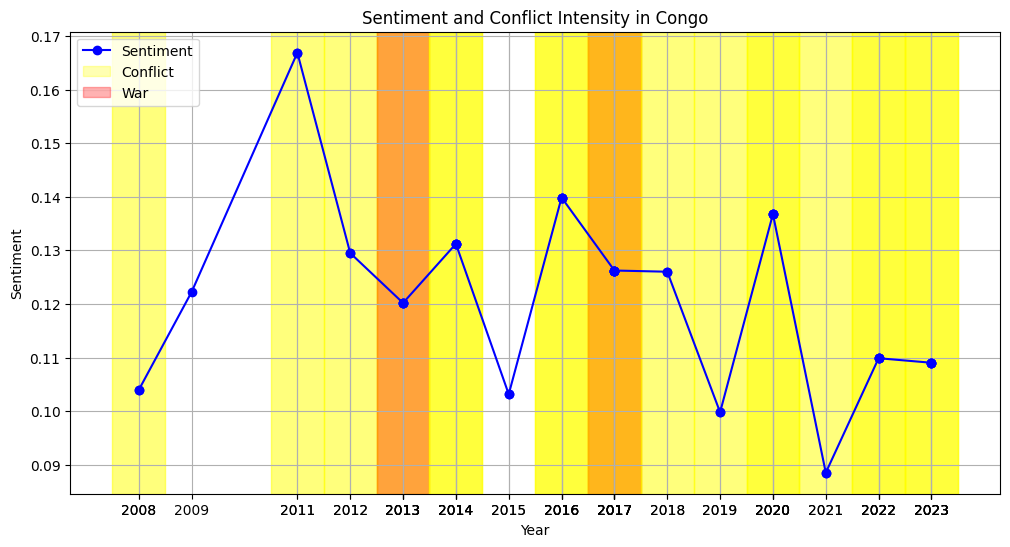

In [91]:
country = 'Congo'

conflicts = final_merged_dataframe[final_merged_dataframe['Country name'] == country]

conflicts = conflicts.sort_values(by='year', ascending=True)

plt.figure(figsize=(12, 6))
plt.plot(conflicts['year'], conflicts['sentiment'], label='Sentiment', color='blue', marker='o')

for i in range(len(conflicts)):
    intensity_level = conflicts['intensity_level'].iloc[i]
    year = conflicts['year'].iloc[i]

    if intensity_level == 1:
        plt.axvspan(year - 0.5, year + 0.5, color='yellow', alpha=0.3, label='Conflict' if 'Conflict' not in plt.gca().get_legend_handles_labels()[1] else "")

    elif intensity_level == 2:
        plt.axvspan(year - 0.5, year + 0.5, color='red', alpha=0.3, label='War' if 'War' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title(f'Sentiment and Conflict Intensity in {country}')
plt.xticks(conflicts['year'].astype(int))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removes duplicates by using dictionary
plt.legend(by_label.values(), by_label.keys())
plt.grid(True)

plt.show()

2. Are there any visible trends in the sentiment of UN speeches given by countries which are the neighbours of countries which have an armed conflict on their territory at the time of the speech?

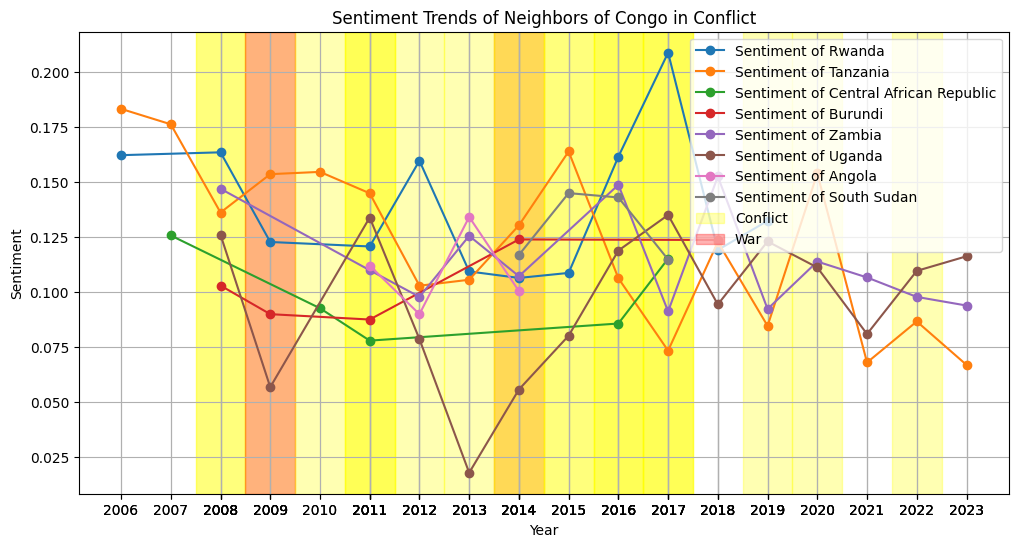

In [92]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

country = 'Congo'

iso_code_of_country = df[df['Country name'] == country]['ISO-alpha3 Code'].iloc[0]
neighbors_of_country = list(G.neighbors(iso_code_of_country))

neighbors_in_conflict = df[(df['ISO-alpha3 Code'].isin(neighbors_of_country)) &
                           (df['neighbor_in_conflict'] == True)]

neighbors_in_conflict = neighbors_in_conflict.sort_values(by='year', ascending=True)

plt.figure(figsize=(12, 6))

for neighbor in neighbors_in_conflict['Country name'].unique():
    neighbor_data = neighbors_in_conflict[neighbors_in_conflict['Country name'] == neighbor]
    plt.plot(neighbor_data['year'], neighbor_data['sentiment'], label=f'Sentiment of {neighbor}', marker='o')

for i in range(len(neighbors_in_conflict)):
    intensity_level = neighbors_in_conflict['intensity_level'].iloc[i]
    year = neighbors_in_conflict['year'].iloc[i]

    if intensity_level == 1:
        plt.axvspan(year - 0.5, year + 0.5, color='yellow', alpha=0.3, label='Conflict' if 'Conflict' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif intensity_level == 2:
        plt.axvspan(year - 0.5, year + 0.5, color='red', alpha=0.3, label='War' if 'War' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title(f'Sentiment Trends of Neighbors of {country} in Conflict')
plt.xticks(neighbors_in_conflict['year'].astype(int))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removes duplicates by using dictionary
plt.legend(by_label.values(), by_label.keys())
plt.grid(True)

plt.show()

3. Are these trends reflected in the positive and negative affect scores of the happiness dataset?

3.1. For the country which has armed conflict on its territory

/var/folders/q9/5p8dw8j11x53h2wkrpcg7czh0000gn/T/ipykernel_38616/3039237701.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna(0, inplace=True)
/var/folders/q9/5p8dw8j11x53h2wkrpcg7czh0000gn/T/ipykernel_38616/3039237701.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('year', group_keys=False).apply(select_row)


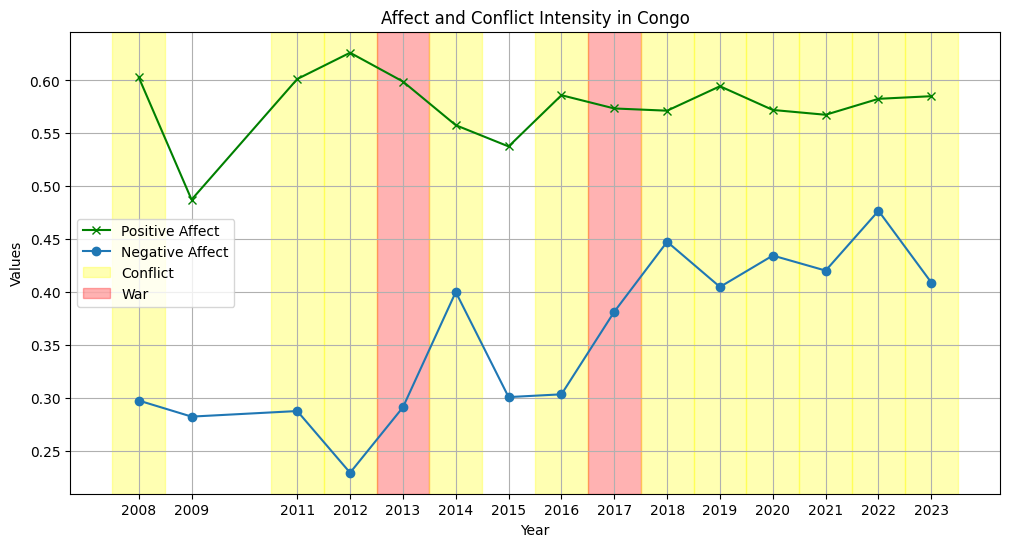

In [93]:
country = 'Congo'

after_2005 = conflictdataframe
conflicts = after_2005[after_2005['location'] == country]

happiness = happinessdataframe[happinessdataframe['Country name'] == country]

merged_df = pd.merge(conflicts, happiness, on='year', how='outer')
merged_df.fillna(0, inplace=True)
merged_df = merged_df.sort_values(by='year', ascending=True)

merged_df = merged_df.groupby('year', group_keys=False).apply(select_row)

merged_df = merged_df.loc[(merged_df['Positive affect'] != 0.000) & (merged_df['Negative affect'] != 0.000)]

plt.figure(figsize=(12, 6))
plt.plot(merged_df['year'], merged_df['Positive affect'], label='Positive Affect', color='green', marker='x')
plt.plot(merged_df['year'], merged_df['Negative affect'], label='Negative Affect', marker='o')

for i in range(len(merged_df)):
    intensity_level = merged_df['intensity_level'].iloc[i]
    year = merged_df['year'].iloc[i]

    if intensity_level == 1:
        plt.axvspan(year - 0.5, year + 0.5, color='yellow', alpha=0.3, label='Conflict' if 'Conflict' not in plt.gca().get_legend_handles_labels()[1] else "")

    elif intensity_level == 2:
        plt.axvspan(year - 0.5, year + 0.5, color='red', alpha=0.3, label='War' if 'War' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Year')
plt.ylabel('Values')
plt.title(f'Affect and Conflict Intensity in {country}')
plt.xticks(merged_df['year'].astype(int))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removes duplicates by using dictionary
plt.legend(by_label.values(), by_label.keys())
plt.grid(True)

plt.show()

3.2. For the neighbors of the country which has armed conflict on its territory

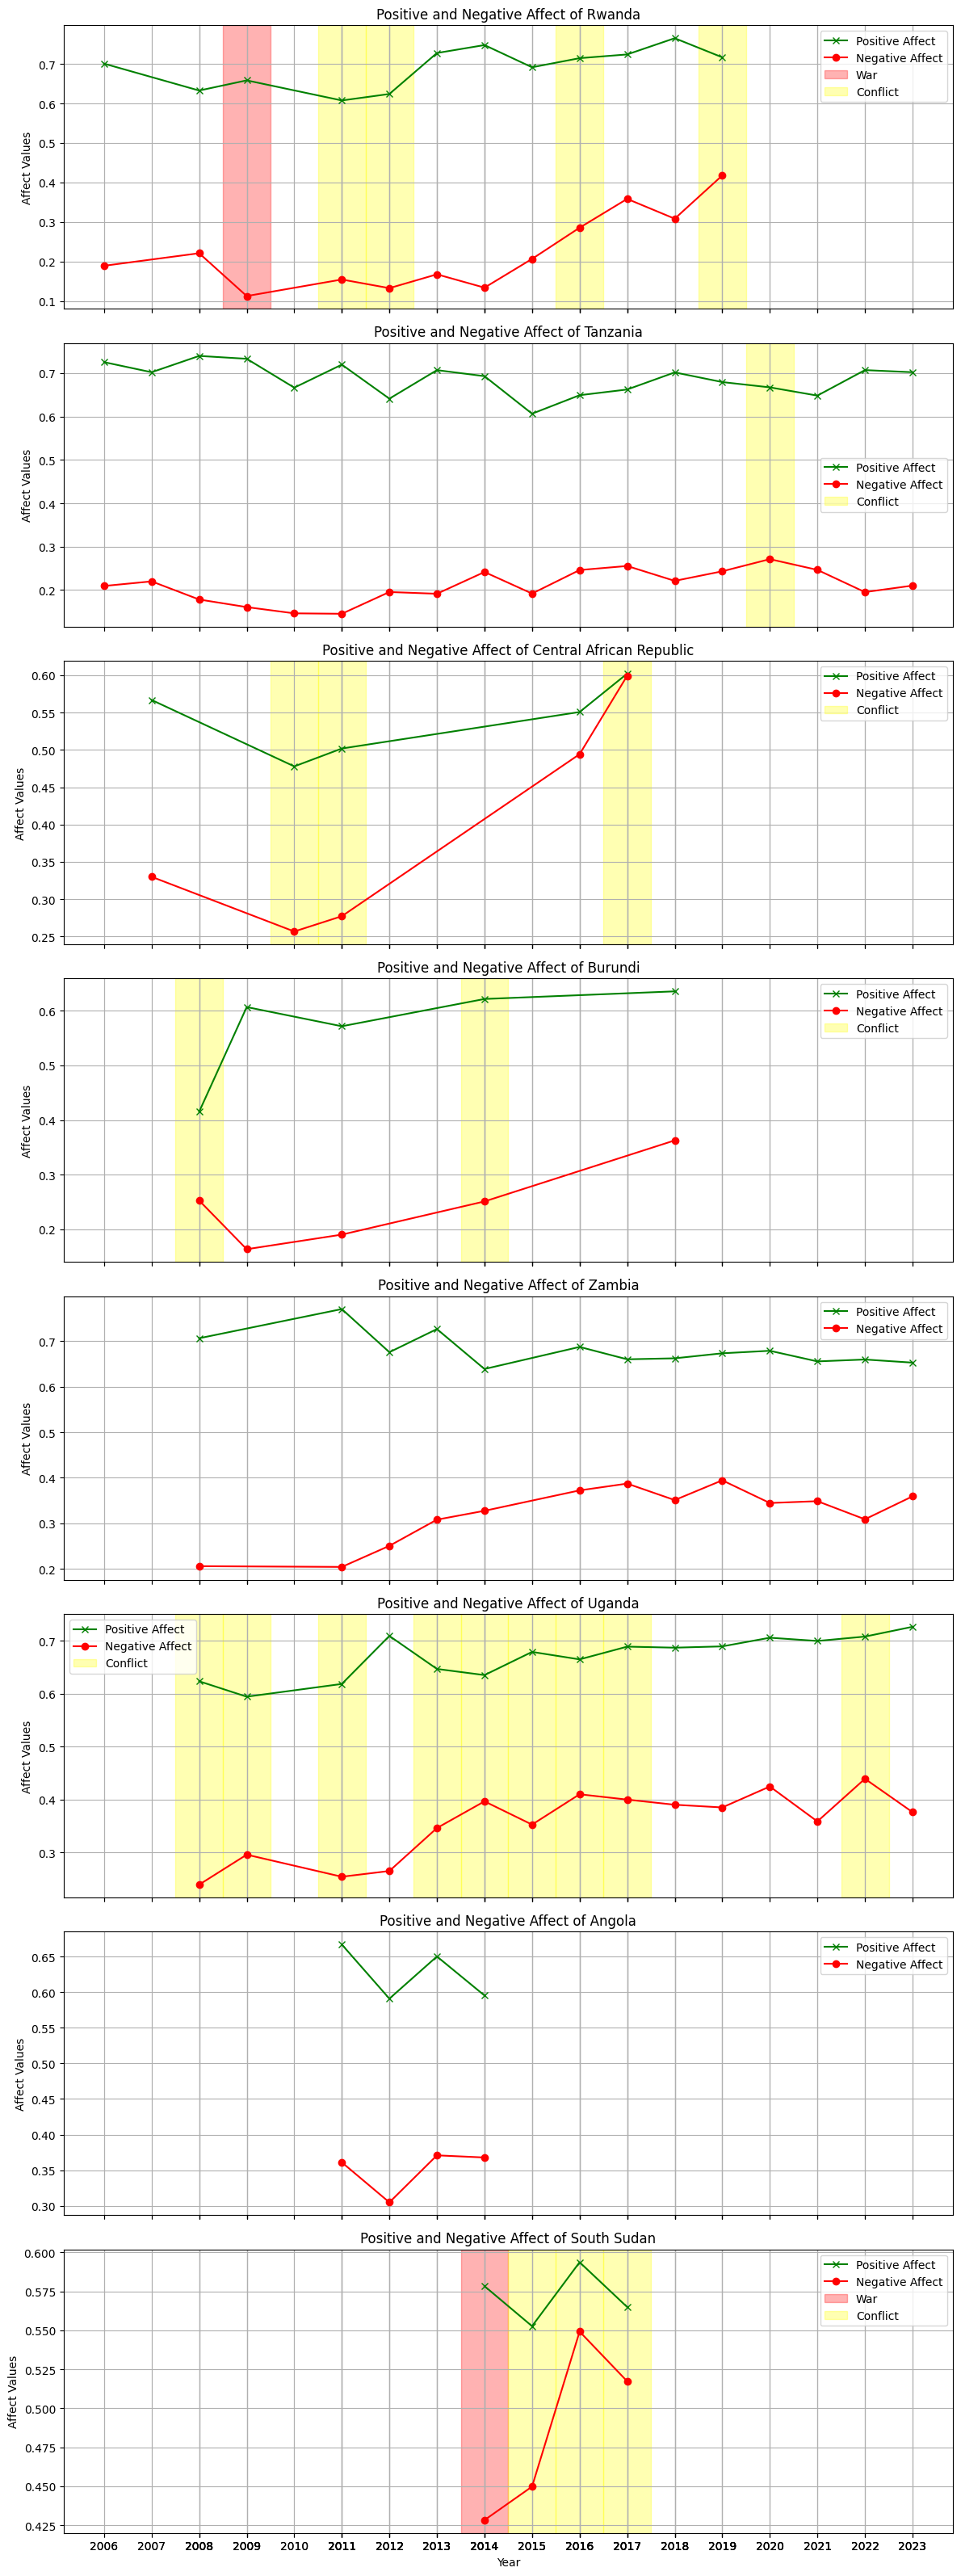

In [94]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

country = 'Congo'

iso_code_of_country = df[df['Country name'] == country]['ISO-alpha3 Code'].iloc[0]
neighbors_of_country = list(G.neighbors(iso_code_of_country))

neighbors_in_conflict = df[(df['ISO-alpha3 Code'].isin(neighbors_of_country)) &
                            (df['neighbor_in_conflict'] == True)]

neighbors_in_conflict = neighbors_in_conflict.sort_values(by='year', ascending=True)

if neighbors_in_conflict.empty:
    print("No valid data available for neighbors of the specified country.")
else:
    num_neighbors = len(neighbors_in_conflict['Country name'].unique())
    fig, axes = plt.subplots(num_neighbors, 1, figsize=(12, 4 * num_neighbors), sharex=True)

    for ax, neighbor in zip(axes, neighbors_in_conflict['Country name'].unique()):
        neighbor_data = neighbors_in_conflict[neighbors_in_conflict['Country name'] == neighbor]

        ax.plot(neighbor_data['year'], neighbor_data['Positive affect'],
                label='Positive Affect', marker='x', color='green')

        ax.plot(neighbor_data['year'], neighbor_data['Negative affect'],
                label='Negative Affect', marker='o', color='red')

        for i in range(len(neighbor_data)):
            intensity_level = neighbor_data['intensity_level'].iloc[i]
            year = neighbor_data['year'].iloc[i]

            if intensity_level == 1:
                ax.axvspan(year - 0.5, year + 0.5, color='yellow', alpha=0.3,
                           label='Conflict' if 'Conflict' not in ax.get_legend_handles_labels()[1] else "")
            elif intensity_level == 2:
                ax.axvspan(year - 0.5, year + 0.5, color='red', alpha=0.3,
                           label='War' if 'War' not in ax.get_legend_handles_labels()[1] else "")

        ax.set_title(f'Positive and Negative Affect of {neighbor}')
        ax.set_ylabel('Affect Values')
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel('Year')
    plt.xticks(neighbors_in_conflict['year'].astype(int))

    plt.tight_layout()

    plt.show()

# Classification

<h2>Predictive Research Questions</h2>

* Can we predict wether a country has an armed conflict on its territory or is a country neighbouring one with an armed conflict on its territory based on the content of its UN speech?

<h2>Bayesian classifier</h2>

In [7]:
df = pd.read_excel(FINAL_MERGED_DATASET)

X_train, X_test, y_train, y_test = train_test_split(df['Speech'], df['neighbor_in_conflict'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 65.82%
Classification Report:
              precision    recall  f1-score   support

       False       0.64      1.00      0.78       316
        True       1.00      0.10      0.18       193

    accuracy                           0.66       509
   macro avg       0.82      0.55      0.48       509
weighted avg       0.78      0.66      0.55       509



In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd

data = pd.read_excel(FINAL_MERGED_DATASET)
data_cleaned = data[['Speech', 'neighbor_in_conflict']].copy()

label_encoder = LabelEncoder()
data_cleaned['neighbor_in_conflict'] = label_encoder.fit_transform(data_cleaned['neighbor_in_conflict'])

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_speech = tfidf_vectorizer.fit_transform(data_cleaned['Speech']).toarray()

y = data_cleaned['neighbor_in_conflict']

X_train, X_test, y_train, y_test = train_test_split(X_speech, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(class_report)

0.762278978388998
[[301  15]
 [106  87]]
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       316
           1       0.85      0.45      0.59       193

    accuracy                           0.76       509
   macro avg       0.80      0.70      0.71       509
weighted avg       0.78      0.76      0.74       509



## Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Speech']).toarray()

y = data_cleaned['neighbor_in_conflict']

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf_rf = rf_tfidf.predict(X_test_tfidf)
accuracy_tfidf_rf = accuracy_score(y_test, y_pred_tfidf_rf)
conf_matrix_tfidf_rf = confusion_matrix(y_test, y_pred_tfidf_rf)
class_report_tfidf_rf = classification_report(y_test, y_pred_tfidf_rf)

print("Random Forest (TF-IDF) Model Evaluation:")
print(f"Accuracy: {accuracy_tfidf_rf * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_tfidf_rf)
print("Classification Report:\n", class_report_tfidf_rf)

Random Forest (TF-IDF) Model Evaluation:
Accuracy: 77.01%
Confusion Matrix:
 [[299  17]
 [100  93]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84       316
           1       0.85      0.48      0.61       193

    accuracy                           0.77       509
   macro avg       0.80      0.71      0.73       509
weighted avg       0.79      0.77      0.75       509



## Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000)

logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
class_report_logreg = classification_report(y_test, y_pred_logreg)

print(accuracy_logreg)
print(conf_matrix_logreg)
print(class_report_logreg)

0.8231827111984283
[[285  31]
 [ 59 134]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       316
           1       0.81      0.69      0.75       193

    accuracy                           0.82       509
   macro avg       0.82      0.80      0.81       509
weighted avg       0.82      0.82      0.82       509



## Logistic Regression + Hyperparameter Tuning

In [71]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

label_encoder = LabelEncoder()
data_cleaned['neighbor_in_conflict'] = label_encoder.fit_transform(data_cleaned['neighbor_in_conflict'])

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_speech = tfidf_vectorizer.fit_transform(data_cleaned['Speech']).toarray()

y = data_cleaned['neighbor_in_conflict']

X_train, X_test, y_train, y_test = train_test_split(X_speech, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 5, 10, 20, 50, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [1000, 2000, 3000],  # Increasing iterations to ensure convergence
}

logreg_tuning = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(logreg_tuning, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

best_params, best_score, accuracy_best, conf_matrix_best, class_report_best

/opt/anaconda3/envs/debates_analysis/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/debates_analysis/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/debates_analysis/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/debates_analysis/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/debates_analysis/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


({'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'},
 0.8010779496073613,
 0.8133595284872298,
 array([[269,  47],
        [ 48, 145]]),
 '              precision    recall  f1-score   support\n\n           0       0.85      0.85      0.85       316\n           1       0.76      0.75      0.75       193\n\n    accuracy                           0.81       509\n   macro avg       0.80      0.80      0.80       509\nweighted avg       0.81      0.81      0.81       509\n')

# Logistic Regression w/ Word2Vec or BERT 

In [38]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel

data_cleaned['neighbor_in_conflict'] = data_cleaned['neighbor_in_conflict'].apply(lambda x: 1 if x == True else 0)

tokenized_speeches = [speech.split() for speech in data_cleaned['Speech']]

word2vec_model = Word2Vec(sentences=tokenized_speeches, vector_size=100, window=5, min_count=1, workers=4)

def get_avg_word2vec_vector(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

X_word2vec = np.array([get_avg_word2vec_vector(tokens, word2vec_model) for tokens in tokenized_speeches])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()

X_bert = np.array([get_bert_embedding(speech, tokenizer, model) for speech in data_cleaned['Speech']])

y = data_cleaned['neighbor_in_conflict']

X_train_word2vec, X_test_word2vec, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y, test_size=0.2, random_state=42)

logreg_word2vec = LogisticRegression(C=10, max_iter=1000, penalty='l2', solver='lbfgs')
logreg_bert = LogisticRegression(C=10, max_iter=1000, penalty='l2', solver='lbfgs')

logreg_word2vec.fit(X_train_word2vec, y_train)
logreg_bert.fit(X_train_bert, y_train_bert)

y_pred_word2vec = logreg_word2vec.predict(X_test_word2vec)
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
conf_matrix_word2vec = confusion_matrix(y_test, y_pred_word2vec)
class_report_word2vec = classification_report(y_test, y_pred_word2vec)

print("Word2Vec Model Evaluation:")
print(f"Accuracy: {accuracy_word2vec * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_word2vec)
print("Classification Report:\n", class_report_word2vec)

y_pred_bert = logreg_bert.predict(X_test_bert)
accuracy_bert = accuracy_score(y_test_bert, y_pred_bert)
conf_matrix_bert = confusion_matrix(y_test_bert, y_pred_bert)
class_report_bert = classification_report(y_test_bert, y_pred_bert)

print("\nBERT Model Evaluation:")
print(f"Accuracy: {accuracy_bert * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_bert)
print("Classification Report:\n", class_report_bert)

Word2Vec Model Evaluation:
Accuracy: 75.44%
Confusion Matrix:
 [[262  54]
 [ 71 122]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       316
           1       0.69      0.63      0.66       193

    accuracy                           0.75       509
   macro avg       0.74      0.73      0.73       509
weighted avg       0.75      0.75      0.75       509


BERT Model Evaluation:
Accuracy: 77.21%
Confusion Matrix:
 [[262  54]
 [ 62 131]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       316
           1       0.71      0.68      0.69       193

    accuracy                           0.77       509
   macro avg       0.76      0.75      0.76       509
weighted avg       0.77      0.77      0.77       509



## Analysis of Unbalanced Dataset

In [41]:
class_distribution = data_cleaned['neighbor_in_conflict'].value_counts()
print("Class Distribution (Counts):")
print(class_distribution)

class_distribution_percentage = (class_distribution / len(data_cleaned)) * 100
print("\nClass Distribution (Percentage):")
print(class_distribution_percentage)

Class Distribution (Counts):
neighbor_in_conflict
0    1567
1     978
Name: count, dtype: int64

Class Distribution (Percentage):
neighbor_in_conflict
0    61.571709
1    38.428291
Name: count, dtype: float64


## Logistic Regression vs (Balanced) Logistic Regression  


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Speech']).toarray()

y = data_cleaned['neighbor_in_conflict']

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

logreg_no_balance = LogisticRegression(C=10, max_iter=1000, penalty='l2', solver='lbfgs')

logreg_no_balance.fit(X_train_tfidf, y_train)

y_pred_no_balance = logreg_no_balance.predict(X_test_tfidf)
accuracy_no_balance = accuracy_score(y_test, y_pred_no_balance)
conf_matrix_no_balance = confusion_matrix(y_test, y_pred_no_balance)
class_report_no_balance = classification_report(y_test, y_pred_no_balance)

logreg_balanced = LogisticRegression(C=10, max_iter=1000, penalty='l2', solver='lbfgs', class_weight='balanced')

logreg_balanced.fit(X_train_tfidf, y_train)

y_pred_balanced = logreg_balanced.predict(X_test_tfidf)
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
class_report_balanced = classification_report(y_test, y_pred_balanced)

print("Logistic Regression Without Class Weight Balancing:")
print(f"Accuracy: {accuracy_no_balance * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_no_balance)
print("Classification Report:\n", class_report_no_balance)

print("\nLogistic Regression With Class Weight Balancing:")
print(f"Accuracy: {accuracy_balanced * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_balanced)
print("Classification Report:\n", class_report_balanced)

Logistic Regression Without Class Weight Balancing:
Accuracy: 81.34%
Confusion Matrix:
 [[269  47]
 [ 48 145]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       316
           1       0.76      0.75      0.75       193

    accuracy                           0.81       509
   macro avg       0.80      0.80      0.80       509
weighted avg       0.81      0.81      0.81       509


Logistic Regression With Class Weight Balancing:
Accuracy: 80.35%
Confusion Matrix:
 [[254  62]
 [ 38 155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.84       316
           1       0.71      0.80      0.76       193

    accuracy                           0.80       509
   macro avg       0.79      0.80      0.80       509
weighted avg       0.81      0.80      0.81       509



## Bagging: Finetuned Logistic Regression w/o Balance Class Weights 

In [52]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Speech']).toarray()

y = data_cleaned['neighbor_in_conflict']

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(C=10, max_iter=1000, penalty='l2', solver='lbfgs')

bagging = BaggingClassifier(estimator=logreg, n_estimators=1000, bootstrap=True, random_state=42)

bagging.fit(X_train_tfidf, y_train)

y_pred_bagging = bagging.predict(X_test_tfidf)

accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
conf_matrix_bagging = confusion_matrix(y_test, y_pred_bagging)
class_report_bagging = classification_report(y_test, y_pred_bagging)

print("Bagging with Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_bagging * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_bagging)
print("Classification Report:\n", class_report_bagging)

Bagging with Logistic Regression Model Evaluation:
Accuracy: 81.53%
Confusion Matrix:
 [[273  43]
 [ 51 142]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       316
           1       0.77      0.74      0.75       193

    accuracy                           0.82       509
   macro avg       0.81      0.80      0.80       509
weighted avg       0.81      0.82      0.81       509



## Boostraping: Finetuned Logistic Regression w/o Balance Class Weights

In [53]:
import numpy as np
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Number of bootstrap samples
n_iterations = 100  

# Size of each bootstrap sample
n_size = int(len(X_train_tfidf))  

predictions = np.zeros((n_iterations, len(X_test_tfidf)))

for i in range(n_iterations):
    X_train_bootstrap, y_train_bootstrap = resample(X_train_tfidf, y_train, n_samples=n_size, random_state=i)
    
    logreg = LogisticRegression(C=10, max_iter=1000, penalty='l2', solver='lbfgs')
    
    logreg.fit(X_train_bootstrap, y_train_bootstrap)
    
    y_pred = logreg.predict(X_test_tfidf)
    
    predictions[i, :] = y_pred

final_predictions = np.round(np.mean(predictions, axis=0))

accuracy = accuracy_score(y_test, final_predictions)
conf_matrix = confusion_matrix(y_test, final_predictions)
class_report = classification_report(y_test, final_predictions)

print("Bootstrapped Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Bootstrapped Logistic Regression Model Evaluation:
Accuracy: 82.12%
Confusion Matrix:
 [[274  42]
 [ 49 144]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       316
           1       0.77      0.75      0.76       193

    accuracy                           0.82       509
   macro avg       0.81      0.81      0.81       509
weighted avg       0.82      0.82      0.82       509

